In [1]:
import cobaya
from cobaya.likelihood import Likelihood
from cobaya.model import get_model
from cobaya.model import Model
from cobaya.run import run
import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt
import vega.vega_interface
import vega.model
import vega.power_spectrum
from vega.vega_interface import VegaInterface, Minimizer

import scipy
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

In [28]:
class Likelihood(Likelihood): # class that inherits from cobaya.likelihood

    def initialize(self, **params_values):
        '''
        Set up initial parameters
        '''
        self.vega = VegaInterface('configs/complex_main.ini') # Creates an instance of VegaInterface with a configuration file containing cosmological or model parameters
        
        # Check if we need to run over a Monte Carlo mock
        if 'control' in self.vega.main_config:
            run_montecarlo = self.vega.main_config['control'].getboolean('run_montecarlo', False)
            if run_montecarlo and self.vega.mc_config is not None:
                # Get the MC seed and forecast flag
                seed = self.vega.main_config['control'].getint('mc_seed', 0)
                forecast = self.vega.main_config['control'].getboolean('forecast', False)

                # Create the mocks
                self.vega.monte_carlo_sim(self.vega.mc_config['params'], seed=seed, forecast=forecast)

                # Set to sample the MC params
                sampling_params = self.vega.mc_config['sample']
                self.vega.minimizer = Minimizer(self.vega.chi2, sampling_params)
            elif run_montecarlo:
                raise ValueError('You asked to run over a Monte Carlo simulation,'
                                 ' but no "[monte carlo]" section provided.')
        
        self.effective_redshift = 2.33
        self.k_grid = np.logspace(-3,1,260) # grid of scales for power spectrum
        self.vega.fiducial['z_fiducial'] = self.effective_redshift   # fix z_eff z_fiducial

    def get_requirements(self):
        '''
        Specifies what cosmological parameters are required by cobaya
        '''
        return {'bias_LYA': None, 'beta_LYA': None,'D_M_fid': None, 'D_H_fid': None, 'or_photon':None, 'or_neutrino':None, \
                'H0': None, 'ombh2': None , 'omch2': None, 'omnuh2': None, 'omk': None,'As': None, 'ns': None, \
                'Pk_grid': {'z': [self.effective_redshift], 'k_max':10, 'nonlinear':[False]},
                'angular_diameter_distance':{'z': [self.effective_redshift]}, 'Hubble':{'z': [self.effective_redshift]},
                }

    def logp(self, **params_values):
        '''
        Method to calculate the log-likelihood based on the parameters provided
        '''
        scale_factor = 1/(1+self.effective_redshift) # scale factor at effective redshift
        h = params_values['H0']/100 # defines the reduced Hubble constant from provided H0
        D_M = (self.provider.get_angular_diameter_distance(self.effective_redshift)/scale_factor)*h # computes angular diameter distance to effective redshift 
        D_H = ((scipy.constants.c/1000)/self.provider.get_Hubble(self.effective_redshift))*h # computes Hubble distance
        params_values['ap_full'] = D_H[0]/params_values['D_H_fid'] # computes alpha_parallel 
        params_values['at_full'] = D_M[0]/params_values['D_M_fid'] # computes alpha_transverse

        k_Mpc, z, pk_Mpc = self.provider.get_Pk_grid(nonlinear = False) # retrieves power spectrum
        cs = interp1d(np.array(k_Mpc/h), np.array(pk_Mpc*(h**3)), kind='cubic')
        k_hMpc = self.k_grid # initial grid is in units of Mpc/h
        pk_hMpc = cs(k_hMpc)
        
        if 'pk_full' not in self.vega.fiducial.keys(): # if vega fiducial pk_full is empty, store it here
            print("self.vega.fiducial is empty")
            self.vega.fiducial['k'] = k_hMpc
            self.vega.fiducial['pk_full'] = pk_hMpc
        self.pk_full = pk_hMpc
            
        omega_m = (params_values['ombh2'] + params_values['omch2'] + params_values['omnuh2'])/(h**2) # computes Omega_m from baryons, cold dark matter, and non-relativistic neutrinos 
        self.vega.fiducial['Omega_m'] = omega_m
        self.vega.fiducial['Omega_de'] = (1 - params_values['omk'] - params_values['or_photon'] - params_values['or_neutrino'] - omega_m) # computes Omega_de from Omega_m, flatness, photons, and relativistic neutrinos

        # compute and save model
        self.vega_model = self.vega.compute_model(params_values, direct_pk = self.pk_full, run_init=False)
        #print('vega model computed')
        
        chi2 = self.vega.chi2(params_values, direct_pk = self.pk_full) # uses vega to compute chi2 from power spectrum and parameter values 
        #print('param values:', params_values)
        print('chi2:', chi2)
        return -chi2 / 2 # returns log likelihood

In [29]:
info_minimize = {
    "output": None,
    "likelihood": {
        "custom_likelihood": {
            "class": Likelihood
        }
    },
    "params": {
        "As": {
            "latex": "A_s",
            "value": 2.1e-9
        },
        "D_H_fid": {
            "latex": "D_{H, fid}",
            "value": 853.772277153506
        },
        "D_M_fid": {
            "latex": "D_{M, fid}",
            "value": 3882.64271129613
        },
        "H0": {
            "prior": {
                "min": 40,
                "max": 100
            },
            "ref": {
                "dist": "norm",
                "loc": 67.36,
                "scale": 3
            },
            "latex": "H_0"
        },
        "rdrag": {
            "latex": "r_d"
        },
        "H0_rd": {
            "derived": "lambda H0, rdrag: H0*rdrag/299792"
        },
        "beta_LYA": {
            "latex": r"\beta",
            "value": 1.67
        },
        "bias_LYA": {
            "latex": "bias",
            "value": -0.1171
        },
        "or_photon": {
            "value": 5.44985776336301e-05,
            "latex": r"\Omega_{r,\gamma}"
        },
        "or_neutrino": {
            "value": 2.5133613689346e-05,
            "latex": r"\Omega_{r,\nu}"
        },
        "ns": {
            "latex": "n_s",
            "value": 0.9649
        },
        "ombh2": {
            "latex": r"\Omega_\mathrm{b} h^2",
            "value": 0.02237
        },
        "omch2": {
            "value": "lambda omegam, ombh2, mnu, H0: (omegam)*(H0/100)**2 - ombh2 -(mnu*(3.046/3)**0.75)/94.0708",
            "latex": r"\Omega_\mathrm{c} h^2"
        },
        "omegam": {
            "prior": {
                "min": 0.01,
                "max": 0.99
            },
            "latex": r"\Omega_\mathrm{m}"
        },
        "omegal": {
            "latex": r"\Omega_\Lambda"
        },
        "mnu": 0.06,
        "tau": 0.055
    },
    "sampler": {
        "minimize": {
            "method": "iminuit",
            "max_evals": 1e6
        }
    },
    "theory": {
        "camb": {
            "extra_args": {
                "WantDerivedParameters": True
            }
        }
    }
}

In [45]:
params = {'As': 2.1e-9,
 'D_H_fid': 853.772277153506,
 'D_M_fid': 3882.64271129613,
 'H0': 67.36,
 'beta_LYA': 1.67,
 'bias_LYA': -0.1171,
 'or_photon': 5.44985776336301e-05,
 'or_neutrino': 2.5133613689346e-05,
 'ns': 0.9649,
 'ombh2': 0.02237,
 'omegam': 0.315305}

In [41]:
model = get_model(info_minimize)

[model] *WARNING* Ignored blocks/options: ['sampler']
[camb] `camb` module loaded successfully from /global/u2/w/wmturner/.conda/envs/lya-directfit/lib/python3.12/site-packages/code/CAMB/camb
INFO: reading input Pk /global/homes/w/wmturner/repos/vega/cobaya_interface/templates/DESI-2024_z_2.33_new_k-grid.fits
Reading data file /pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/cf_lya_x_lya_exp_no-dist.fits

Reading data file /pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/xcf_qso_x_lya_exp_no-dist.fits

LOG: Full matrix is positive definite
LOG: Reduced matrix is positive definite


In [42]:
%%timeit
model.loglike(params)

chi2: 83.18411596110423
255 μs ± 53.5 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
print(model.loglike(params))

chi2: 0.01862217968154229
(-0.009311089840771145, [147.08792296637432, 0.03304905564863296, 0.12005039376771415, 0.6846159778288341])


In [24]:
# Extract model
likelihood_instance = model.likelihood['custom_likelihood']
vega_model = likelihood_instance.vega_model

INFO: reading input Pk /global/homes/w/wmturner/repos/vega/cobaya_interface/templates/DESI-2024_z_2.33_new_k-grid.fits
Reading data file /pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/cf_lya_x_lya_exp_no-dist.fits

Reading data file /pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/xcf_qso_x_lya_exp_no-dist.fits



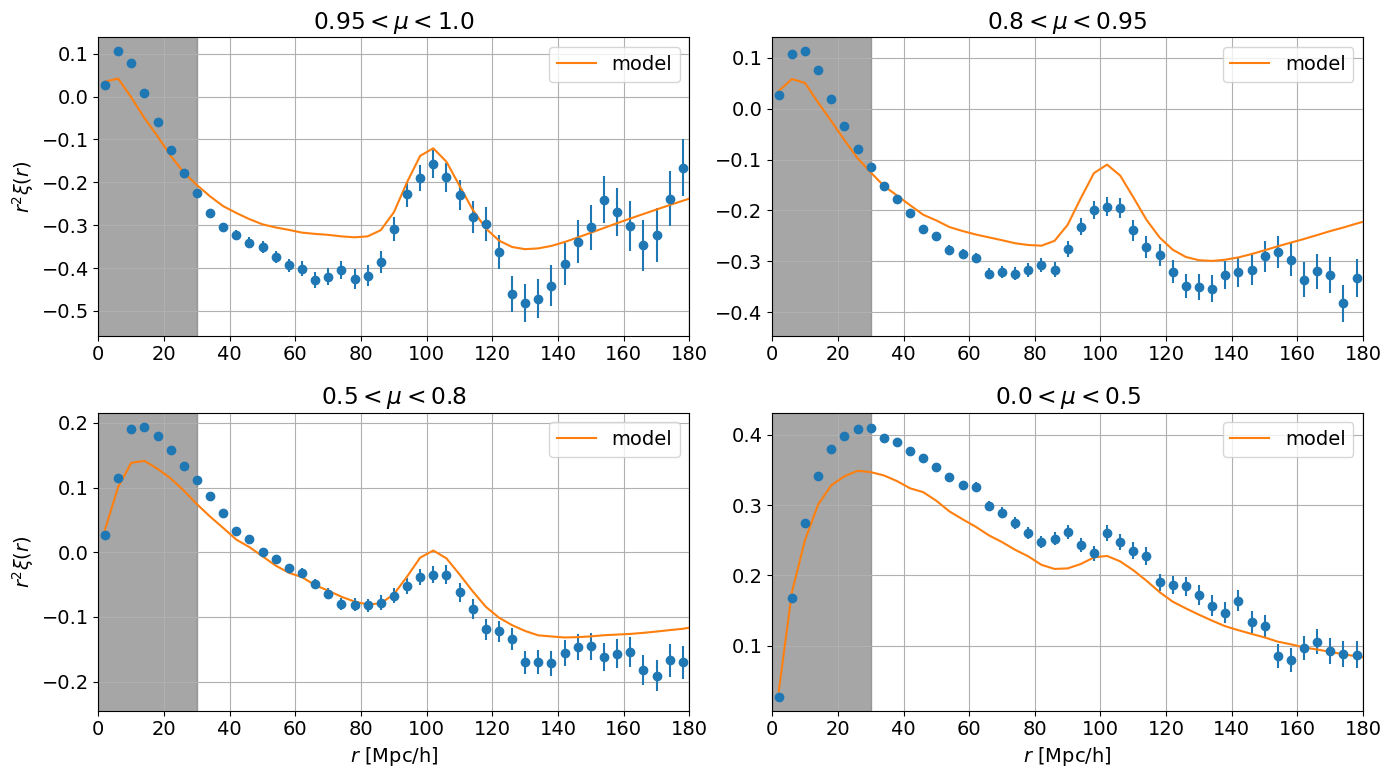

In [26]:
# Plot vega model in wedges (note this is set up in forecasting mode, so the model doesn't need to look like a good fit to the data)
vega = VegaInterface('$HOME/repos/vega/cobaya_interface/configs/complex_main.ini')
vega.plots.plot_4wedges(models=[vega_model['lyalya_lyalya']],
                        labels=['model'], corr_name='lyalya_lyalya',
                        model_colors=['C1'])

In [44]:
# Run minimizer
updated_info, sampler = run(info_minimize)

[camb] `camb` module loaded successfully from /global/u2/w/wmturner/.conda/envs/lya-directfit/lib/python3.12/site-packages/code/CAMB/camb
INFO: reading input Pk /global/homes/w/wmturner/repos/vega/cobaya_interface/templates/DESI-2024_z_2.33_new_k-grid.fits
Reading data file /pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/cf_lya_x_lya_exp_no-dist.fits

Reading data file /pscratch/sd/w/wmturner/picca_runs_v3/uncontaminated_mock/truth/full/xcf_qso_x_lya_exp_no-dist.fits

LOG: Full matrix is positive definite
LOG: Reduced matrix is positive definite
[minimize] Initializing
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
chi2: 70010.16567016493
[minimize] Run 1/2 will start from random initial point:
[minimize] {'H0': 68.93535676137607, 'omegam': 0.9533830102911319}
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
chi